# Deep Guitar Amplifier

A little project to practice Tensorflow/Keras. I use deep learning to simulate a guitar amplifier following the approach published in [Wright et al., 2020](https://www.mdpi.com/2076-3417/10/3/766/htm).

The dataset for the project, available [here](https://www.dropbox.com/s/e09uhp3syjnyrmc/wav.rar?dl=0), consists of .wav files containing recordings of raw electric guitar (used as input to the NN models) and corresponding amplifier sounds (which are the target outputs for the NN models). Download and unzip the dataset into a folder of your chosing and make sure to assign the correct path to the variable `data_dir` in the following cell. Then, run the following cell to load the dependences. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import spectrogram, get_window
from importlib import reload
import utils, models
reload(utils)
reload(models)
from utils import *
from models import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as kb
from sklearn.model_selection import train_test_split
from IPython.display import display, Audio

%matplotlib inline

# gpu memory management (attempt to allocate only as much memory as needed)
# check https://www.tensorflow.org/guide/gpu
# this instruction is required, otherwise cudnn returns errors
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# data directories
data_dir = "C:/Users/tore-/Dropbox/Projects/deep guitar amp emulation/datasets/guitar_amplifier_dataset/wav/"
data_proc_dir = 'datasets/guitar_amplifier_dataset/processed/'

# specify the training path (where all training progress is going to be saved)
training_path = 'models/'
if not os.path.exists(training_path): os.makedirs(training_path)
    
# default samplerate for wav data (this variable is ovewritten if dataset is loaded)
samplerate = 44100

# amplifier to be modelled
amp = 'markII'
amp_gain = 'gain6'

# specify the device that tensorflow should use
# '/gpu:0' or '/cpu:0'
tf_device = '/gpu:0'

# specify the pre-emphasis filter used in the loss function during training
preemphasis_weights=[-.85,1]
Preemphasis = tf.constant(preemphasis_weights, 
                          shape=[len(preemphasis_weights),1,1], 
                          dtype=tf.float32)

# Chunk size for training the model
Tx = round(.1*samplerate) 

# Amounts of samples to reject before loss calculation. This parameter is used
# to exclude the model transients from affecting the loss calculation
Trej = round(.025*samplerate)

# Helper function used to pass the training set to model.fit()
# It chunks the dataset and adds an extra dimension (required by tensorflow)
data_fun = lambda X: np.expand_dims(data_chunk(X, Tx, Trej),2)

Run the following cell to open an ipython console. I find it handy when working with jupyter notebooks.

In [ ]:
# Open the ipython console
%qtconsole --JupyterWidget.font_size=11

## 1 - Dataset

### Wave file processing

The next cell loads the .wav files and chunks them into shorter time windows. It then shuffles the windows and splits them into a training, validation and test set (proportions: 80%, 10%, 10%). It finally saves the processed datasets to disk. 

You need to run this cell only the first time you go through this notebook. It will process the .wav files and save the processed dataset for future use. The next times you use this notebook, you won't need to run this cell unless you want to change some processing parameters.

In [20]:
# Load wave dataset
wavedata = load_wavedata(data_dir)

# Split wave data into chunks of Tchunk length (a few seconds long, so that they 
# can be listened to)
Tchunk = round(5*wavedata['samplerate']) 
X = data_chunk(wavedata['input'], Tchunk)
Y = data_chunk(wavedata[amp][amp_gain], Tchunk)

# shuffle and split into train, validation and test datasets
split_prop = [.8, .1, .1]
Xtrain, Xtest, Ytrain, Ytest = \
    train_test_split(X, Y, test_size=split_prop[2], random_state=1)
Xtrain, Xval, Ytrain, Yval = \
    train_test_split(Xtrain, Ytrain, test_size=split_prop[1]/np.sum(split_prop[:2]), random_state=1)

# save train, validation and test datasets
if not os.path.exists(data_proc_dir):
    os.makedirs(data_proc_dir)
np.savez(data_proc_dir + 'training_data.npz', \
         Xtrain=Xtrain, Ytrain=Ytrain, samplerate=wavedata['samplerate'])
np.savez(data_proc_dir + 'validation_data.npz', \
         Xval=Xval, Yval=Yval, samplerate=wavedata['samplerate'])
np.savez(data_proc_dir + 'test_data.npz', \
         Xtest=Xtest, Ytest=Ytest, samplerate=wavedata['samplerate'])

# free RAM
del wavedata, X, Y, Xtest, Ytest

### Load processed dataset

Load training and validation sets, as processed in the previous cell. You need to run this cell every time you go through this notebook.

In [2]:
# Load processed wave data (training and validation sets)
training_data = np.load(data_proc_dir + 'training_data.npz')
validation_data = np.load(data_proc_dir + 'validation_data.npz')
samplerate = training_data['samplerate']
Xtrain = training_data['Xtrain']
Ytrain = training_data['Ytrain']
Xval = validation_data['Xval']
Yval = validation_data['Yval']

### Data exploration

Play and plot an example from the training set (guitar and amplifier sounds).

guitar


markII


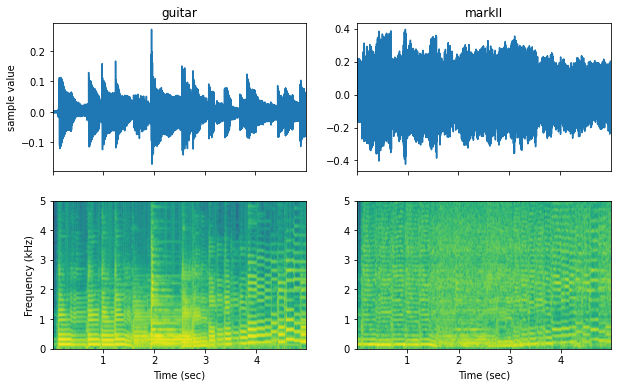

In [4]:
# Example of input/output from the training dataset
idx = 4; 
x = Xtrain[idx,:]
y = Ytrain[idx,:]
t = np.arange(0,len(x))/samplerate

# Play examples
print('guitar')
audio_playback_gui(x)
print(amp)
audio_playback_gui(y)

# Plot wave files
plt.figure(figsize=(10,6))
xlimits = (t[0],t[-1])
ax = plt.subplot(221)
plt.plot(t,x)
ax.set_xticklabels([])
plt.title('guitar')
plt.xlim(xlimits)
plt.ylabel('sample value')
ax = plt.subplot(222)
plt.plot(t,y)
plt.xlim(xlimits)
ax.set_xticklabels([])
plt.title(amp)

# Plot spectrograms 
df = 50; Tn = round_nextpow2(samplerate/df); Tn_overlap = int(.25*Tn)
myspectrogram = lambda x: spectrogram(x, window=get_window('hamming',Tn), fs=samplerate, noverlap=Tn_overlap)
f,t,S = myspectrogram(x)
#f,t,S = spectrogram(x, fs=samplerate)
f /= 1e3; ylimits = (0,5)
ax = plt.subplot(223)
plt.pcolormesh(t, f, 20*np.log10(S), shading='gouraud')
plt.ylabel('Frequency (kHz)')
plt.xlabel('Time (sec)');
plt.ylim(ylimits)
_,_,S = myspectrogram(y)
ax = plt.subplot(224)
plt.pcolormesh(t, f, 20*np.log10(S), shading='gouraud')
plt.xlabel('Time (sec)');
plt.ylim(ylimits);

## 2 - Amplifier model

As done by Wright and colleagues, I use two different neural network architectures (recurrent and convolutional) for black-box modelling of a guitar amplifier. The following cells allow to:

- create and train a new model
- load a trained model and perform some further training
- visualize and hear model outputs

### Initialize a recurrent amplifier model

Initialize an amplifier model based on a recurrent neural network architecture.
Print model summary.

In [16]:
# specify model name
model_name = 'gru_model1'

# model specs
model_specs = """model = recurrent_model(
units=16,
celltype="GRU",
Tx=None,
Trej=Trej,
learning_rate=.01,
name=model_name,
loss=esr_dc(Trej,Preemphasis),
metrics=esr_rej(Trej))"""

# save model specs
with open(training_path + model_name + '_specs.txt','w') as f:
    f.write(model_specs)

# create model
exec(model_specs)
model.summary()

# if a history file with the same model_name already exists, delete it
# so that during training a new file will be generated
history_file = training_path + model_name + '_history.csv'
if os.path.exists(history_file): os.remove(history_file)

Model: "gru_model1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
Xrec (GRU)                      (None, None, 16)     912         X0[0][0]                         
__________________________________________________________________________________________________
Xdense (Dense)                  (None, None, 1)      17          Xrec[0][0]                       
__________________________________________________________________________________________________
Y (Add)                         (None, None, 1)      0           Xdense[0][0]                     
                                                                 X0[0][0]                

### Initialize a convolutional amplifier model

Initialize an amplifier model based on a convolutional neural network architecture. Print model summary.

Some empirical observations:
- for this model, a learning rate of 0.001 works better than 0.01 (used in the recurrent model)
- the parameter that has the strongest effect on performane is the `kernel_size`

In [78]:
# specify model name
model_name = 'conv_model1'

# model specs
model_specs = """model = conv_model(
nlayers=10, 
nchannels=8, 
kernel_size=40,
dilation_rate=2**np.arange(0,10),
learn_difference=False,
activation='tanh',
Tx = None,
Trej=Trej,  
learning_rate=.001,
name=model_name,
loss=esr_dc(Trej,Preemphasis),
metrics=esr_rej(Trej)
)"""

# save model specs
with open(training_path + model_name + '_specs.txt','w') as f:
    f.write(model_specs)

# create model
exec(model_specs)
model.summary()

# if a history file with the same model_name already exists, delete it
# so that during training a new file will be generated
history_file = training_path + model_name + '_history.csv'
if os.path.exists(history_file): os.remove(history_file)

Model: "conv_model1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
Z0 (Conv1D)                     (None, None, 8)      328         X0[0][0]                         
__________________________________________________________________________________________________
Z0_tanh (Activation)            (None, None, 8)      0           Z0[0][0]                         
__________________________________________________________________________________________________
Z0_mix (Conv1D)                 (None, None, 1)      9           Z0_tanh[0][0]                    
________________________________________________________________________________________

### Load a trained amplifier model

Load an existing model.

In [8]:
model_name = 'gru_model'

# load model
exec(open(training_path + model_name + '_specs.txt','r').read())
model.summary()

# Load trained weights
model.load_weights(training_path + model_name + '_weights.hdf5')

Model: "gru_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X0 (InputLayer)                 [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
Xrec (GRU)                      (None, None, 32)     3360        X0[0][0]                         
__________________________________________________________________________________________________
Xdense (Dense)                  (None, None, 1)      33          Xrec[0][0]                       
__________________________________________________________________________________________________
Y (Add)                         (None, None, 1)      0           Xdense[0][0]                     
                                                                 X0[0][0]                 

### Model training

Train the model for a specified number of epochs by running the following cell.
The model weights that produce the lowest validation loss are saved in `<training_path><model_name>.hdf5`. Training history is also saved in `<training_path><model_name>_history.csv`. Every time this cell is run, the corresponding history log is appended to `<training_path><model_name>_history.csv`.

In [17]:
# define a list of callbacks
callback_list = []

# Specify a callback to save the best model's weights
callback_list.append(keras.callbacks.ModelCheckpoint(
    filepath=training_path + model_name + '_weights.hdf5',
    save_weights_only=True,
    save_best_only=True,
    monitor = 'val_loss'))

# Callback to save training history
callback_list.append(keras.callbacks.CSVLogger(
    training_path + model_name + '_history.csv', 
    append=True))

# Callback to stop training if improvement is too low (<min_delta)
# callback_list.append(keras.callbacks.EarlyStopping(
#     monitor="val_loss",
#     min_delta=0.01,
#     patience=5))

# Callback to terminate if loss=NaN
callback_list.append(keras.callbacks.TerminateOnNaN())

# Callback to reduce learning rate if a plateau is reached
callback_list.append(keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=0.001))

# train
tic = time.process_time()
with tf.device(tf_device):
    model.fit(x = data_fun(Xtrain), 
              y = data_fun(Ytrain), 
              epochs=50, 
              batch_size=50, 
              validation_data = (data_fun(Xval), \
                                 data_fun(Yval)),
              callbacks = callback_list
             )
toc = time.process_time()
print('Total training time: ' + str((toc - tic)/60) + ' minutes')

Epoch 1/50
940/940 [==============================] - 149s 156ms/step - loss: 0.8876 - ESR: 0.8067 - val_loss: 0.3825 - val_ESR: 0.2304
Epoch 2/50
940/940 [==============================] - 141s 150ms/step - loss: 0.3553 - ESR: 0.2279 - val_loss: 0.2490 - val_ESR: 0.1862
Epoch 3/50
940/940 [==============================] - 140s 149ms/step - loss: 0.2191 - ESR: 0.1764 - val_loss: 0.1812 - val_ESR: 0.1552
Epoch 4/50
940/940 [==============================] - 143s 152ms/step - loss: 0.1721 - ESR: 0.1413 - val_loss: 0.1420 - val_ESR: 0.1073
Epoch 5/50
940/940 [==============================] - 140s 149ms/step - loss: 0.1408 - ESR: 0.1094 - val_loss: 0.1252 - val_ESR: 0.0974
Epoch 6/50
940/940 [==============================] - 140s 149ms/step - loss: 0.1287 - ESR: 0.1011 - val_loss: 0.1182 - val_ESR: 0.0890
Epoch 7/50
940/940 [==============================] - 141s 150ms/step - loss: 0.1212 - ESR: 0.0963 - val_loss: 0.1117 - val_ESR: 0.0877
Epoch 8/50
940/940 [============================

### Training history

Show model training history. 

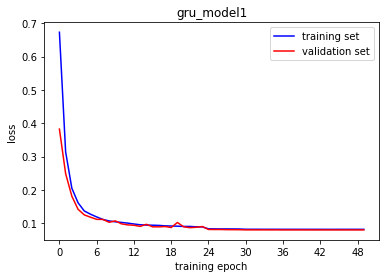

In [18]:
# plot loss curves (training and validation losses)
history = pd.read_csv(training_path + model_name + '_history.csv')
ax = plt.figure().gca()
plt.plot(history['loss'], color='b')
plt.plot(history['val_loss'], color='r')
plt.xlabel('training epoch')
plt.ylabel('loss')
plt.legend(['training set','validation set'])
plt.title(model_name)
#plt.yscale('log')
#plt.xlim(right=50)
ax.xaxis.set_major_locator(MaxNLocator(integer=True));

### Model outputs

Plot and play some examples of model outputs from the training and validation sets.

training example 5: original


training example 5: gru_model1


validation example 5: original


validation example 5: gru_model1


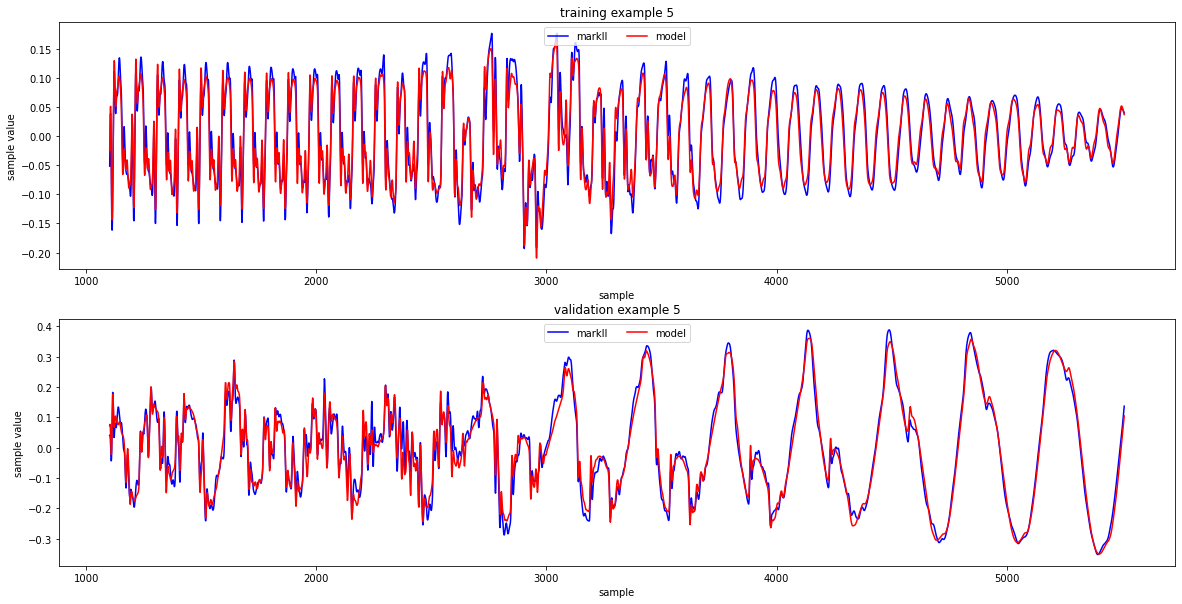

In [19]:
# compute model outputs
idx_vec = [5]
X = np.expand_dims(np.concatenate((Xtrain[idx_vec,:],Xval[idx_vec,:])),2)
Y = np.expand_dims(np.concatenate((Ytrain[idx_vec,:],Yval[idx_vec,:])),2)
with tf.device(tf_device):
    Y_hat = model.predict(X)

# plot examples
samples = np.arange(Trej,Trej+Tx)
plt.figure(figsize=[20, 10])
for k in range(2*len(idx_vec)):
    plt.subplot(2, len(idx_vec), k+1)
    plt.plot(samples, Y[k,samples,0], color='b')
    plt.plot(samples, Y_hat[k,samples,0], color='r')
    plt.xlabel('sample')
    plt.ylabel('sample value')
    plt.legend([amp,'model'], loc='upper center', ncol=2)
    plt.title(('validation' if k>=len(idx_vec) else 'training')+' example '+str(idx_vec[k%len(idx_vec)]));
    
# play examples
for k in range(2*len(idx_vec)):
    print(('validation' if k>=len(idx_vec) else 'training')+\
          ' example '+str(idx_vec[k%len(idx_vec)]) + ': original')
    audio_playback_gui(Y[k,Trej:,0])
    print(('validation' if k>=len(idx_vec) else 'training')+\
          ' example '+str(idx_vec[k%len(idx_vec)]) + ': '+model.name)
    audio_playback_gui(Y_hat[k,Trej:,0])
    

## 3 - Model comparison

Compare a list of models.

In [20]:
# chose models to compare
model_list = ['gru_model', 'gru_model1', 'conv_model', 'conv_model1']
nmodels = len(model_list)

Show training history of selected models.

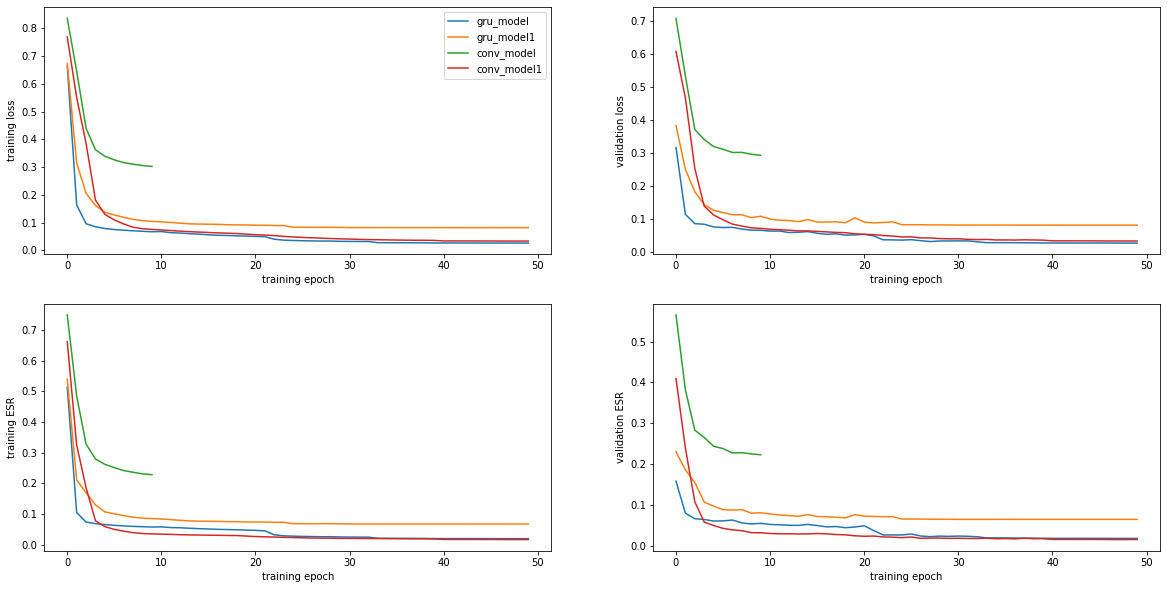

In [21]:
plt.figure(figsize=[20,10])
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
for curr_model in model_list:
    history = pd.read_csv(training_path + curr_model + '_history.csv')
    plt.subplot(ax1)
    plt.plot(history['loss'])
    plt.ylabel('training loss')
    plt.xlabel('training epoch')
    plt.subplot(ax2)
    plt.plot(history['val_loss'])
    plt.ylabel('validation loss')
    plt.xlabel('training epoch')
    plt.subplot(ax3)
    plt.plot(history['ESR'])
    plt.ylabel('training ESR')
    plt.xlabel('training epoch')
    plt.subplot(ax4)
    plt.plot(history['val_ESR'])
    plt.ylabel('validation ESR')
    plt.xlabel('training epoch')
plt.subplot(ax1)
plt.legend(model_list);
